# Asian and Indian Cuisines

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from MachineLearningUtils.preprocessing_data import PreProcessingData
from MachineLearningUtils.naive_bayes_learning import BernoulliNBLearning, MultinomialNBLearning
from MachineLearningUtils.logistic_regression_learning import LogisticRegressionLearning
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, binarize
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
cuisines_df = pd.read_csv('du lieu cung cap/asian_indian_recipes.csv')

In [4]:
cuisines_df.head()

,Unnamed: 0,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,65,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,indian,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,69,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Preprocessing data

*Xóa những feature chỉ có 1 giá trị*

In [5]:
cuisines_df.cuisine.value_counts()

korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64

In [6]:
output_col = 'cuisine'
ppd = PreProcessingData(cuisines_df, 'classification')
print('Total null columns = ', ppd.get_null_column().shape[0])

Total null columns =  0


1. Dữ liệu có dạng ma trận thưa
2. Các Features có dạng nhị phân nhận 2 giá trị 0 và 1 => các cột có độ quan trọng tương đương nhau => không cần giảm số lượng features
3. Dữ liệu dự đoán có dạng category
4. Số mẫu dữ liệu dự đoán của mỗi category tương đối lơn => không cần resampling data
5. Dữ liệu không chưa missing data

=> Một số mô hình để dự đoán phù hơp có thể là: BernoulliNB, LogisticRegression

# Tiền xử lý dữ liệu

In [7]:
# get invalid columns
invalid_cols = ['Unnamed: 0']
for col in cuisines_df.columns:
    if cuisines_df[col].value_counts().shape[0] == 1:
        invalid_cols.append(col)

In [8]:
# remove invalid columns
cuisines_df = cuisines_df.drop(invalid_cols, axis=1)

In [9]:
ppd = PreProcessingData(cuisines_df, 'classification')

In [10]:
le = ppd.label_encode(output_col)
inputs = ppd.data.drop([output_col], axis=1)
output = ppd.data[output_col]

## Sử dụng grid search với cv = 10 để chọn model thích hợp nhất với bộ dữ liệu

In [11]:
ppd.get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LogisticRegression,0.828571
1,GaussianNB,0.537415
2,BernoulliNB,0.832653
3,MultinomialNB,0.834014
4,KNeighborsClassifier,0.712925
5,DecisionTreeClassifier,0.709796
6,RandomForestClassifier,0.763537
7,SVC,0.797279


Từ kết quả của grid search cv chọn
1. LogisticRegression
2. BernoulliNB
3. MultinomialNB

### Đánh giá dữ liệu với LogisticRegression

In [12]:
lr = LogisticRegressionLearning(input_data=inputs, output_data=output, mode='classification')
lr.train_test_split(test_size=0.3)
gscv = lr.get_best_params()
lr.build_model()
lr_model = lr.model

In [13]:
lr.best_params

{'C': 1, 'solver': 'newton-cg'}

In [14]:
lr_model.score(lr.X_train, lr.y_train), lr_model.score(lr.X_test, lr.y_test)

(0.8704028021015762, 0.8285714285714286)

### Đánh giá dữ liệu với BernoulliNB

In [15]:
bnb = BernoulliNBLearning(input_data=inputs, output_data=output, mode='classification')
bnb.train_test_split(test_size=0.3)
gscv = bnb.get_best_params()
bnb.build_model()
bnb_model = bnb.model

In [16]:
bnb.best_params

{'alpha': 0.7}

In [17]:
bnb_model.score(bnb.X_train, bnb.y_train), bnb_model.score(bnb.X_test, bnb.y_test)

(0.8137769994162288, 0.8340136054421768)

### Đánh giá dữ liệu với MultinomialNB

In [18]:
mnb = MultinomialNBLearning(input_data=inputs, output_data=output, mode='classification')
mnb.train_test_split(test_size=0.3)
gscv = mnb.get_best_params()
mnb.build_model()
mnb_model = mnb.model

In [19]:
mnb.best_params

{'alpha': 0.5}

In [20]:
mnb_model.score(mnb.X_train, mnb.y_train), mnb_model.score(mnb.X_test, mnb.y_test)

(0.8213660245183888, 0.8326530612244898)

### 1. Tạo X_train, X_test, y_train, y_test từ dữ liệu đã đọc và chuẩn hóa,với tỷ lệ dữ liệu test là 0.3

In [21]:
X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.3, random_state=42)

### 2. Dựa vào kết quả chạy thử grib search và chọn best params ==> chọn BernoulliNB với alpha=0.9

In [41]:
from sklearn.naive_bayes import BernoulliNB

cuisine_model = BernoulliNB(alpha=0.5)
cuisine_model.fit(X_train, y_train)

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)

### 3. Đánh giá model

In [42]:
y_pred = cuisine_model.predict(X_test)

In [43]:
print('Độ chính xác trên tập Train: ', cuisine_model.score(X_train, y_train)*100, '%')
print('Độ chính xác trên tập Test: ', cuisine_model.score(X_test, y_test)*100, '%')
print('Độ chính xác trên toàn dữ liệu: ', cuisine_model.score(inputs, output)*100, '%')

Độ chính xác trên tập Train:  82.07822533566842 %
Độ chính xác trên tập Test:  83.40136054421768 %
Độ chính xác trên toàn dữ liệu:  82.47549019607843 %


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       145
           1       0.92      0.93      0.93       177
           2       0.62      0.64      0.63        88
           3       0.86      0.86      0.86       229
           4       0.90      0.82      0.86        96

    accuracy                           0.83       735
   macro avg       0.82      0.81      0.81       735
weighted avg       0.84      0.83      0.83       735



In [26]:
print(confusion_matrix(y_test, y_pred))

[[115   4   7  18   1]
 [  0 165   7   2   3]
 [ 12   1  56  15   4]
 [ 11   1  15 201   1]
 [  7   8   3   2  76]]


**Summary about the model:**
1. High precision: ~0.82, High recall: ~0.81
2. High training R^2 score: ~0.81 and High testing score: ~0.83, nearly the same

=> The good model

### 4. Trực quan hóa kết quả dự đoán được từ model

In [27]:
# chọn column để trực quan hóa dữ liệu
ppd.get_k_best_features_by_random_forest(output_col, 3)

cumin                  0.051238
roasted_sesame_seed    0.035538
turmeric               0.029748
dtype: float64

In [28]:
print('Độ chính xác của model là ', accuracy_score(y_test, cuisine_model.predict(X_test))*100, '%')

Độ chính xác của model là  83.40136054421768 %


In [29]:
y_pred = cuisine_model.predict(X_test)
y_prob = cuisine_model.predict_proba(X_test)

In [30]:
lb = LabelBinarizer()
lb.fit(y_test)

y_btest = lb.transform(y_test)
y_bpred = lb.transform(y_pred)
y_bprob = binarize(y_prob, 0.35)

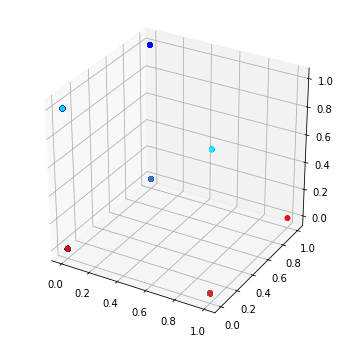

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, projection='3d')

colors = ('red', 'blue', 'green', 'gray', 'cyan')
color = [colors[x] for x in y_pred]
ax.scatter(X_test.sesame_oil, X_test.cilantro, X_test.turmeric, color=color)
plt.show()

In [32]:
roc_auc_score(y_btest, y_bpred), roc_auc_score(y_btest, y_bprob)

(0.8818463256999121, 0.8885822798785418)

In [33]:
n_classes = y_btest.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_btest[:, i], y_bprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_btest.ravel(), y_bprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

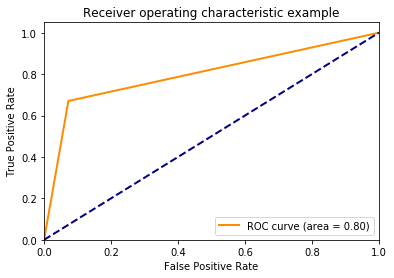

In [34]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Nhận xét ROC
1. ROC curve đạt khoảng 80%, giá trị chạm ngưỡng tốt
2. Có một điểm cắt ở (0.66, 0.8)

### 5. Dựa trên kết quả, hãy cho biết nếu trong thành phần của món ăn có “cumin” và “fish” nhưng không có “yogurt” thì món ăn đó thường là món ăn của nước nào?

In [35]:
cuisines_df[(cuisines_df.cumin == 1) & (cuisines_df.fish == 1) & (cuisines_df.yogurt == 0)].cuisine.value_counts()

4    44
2     3
1     3
3     2
Name: cuisine, dtype: int64

Dựa vào kết quả trên, nếu thành phần món ăn có cumin và fish nhưng không có yourt thì món ăn đó thường là của Thái

### 6. Dựa trên kết quả, hãy cho biết nếu trong thành phần của món ăn có “cumin” nhưng khôngcó “fish”  và không có  “soy_sauce” thì món ăn đó thường là món ăn của nước nào?

In [36]:
cuisines_df[(cuisines_df.cumin == 1) & (cuisines_df.fish == 0) & (cuisines_df.soy_sauce == 0)].cuisine.value_counts()

1    346
4     25
2      2
3      1
0      1
Name: cuisine, dtype: int64

Dựa vào kết quả trên, nếu thành phần món ăn có cumin, nhưng không có fish và soy_sauce thì món ăn đó thường là của Indian

### 7. In nội dungconfusion matrix

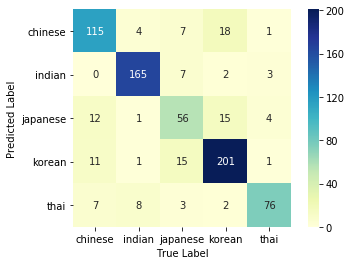

In [37]:
y_pred = cuisine_model.predict(X_test)
y_test_r = le.inverse_transform(y_test)
y_pred_r = le.inverse_transform(y_pred)
contries = np.unique(y_test_r)

mat = confusion_matrix(y_test_r, y_pred_r)

sns.heatmap(
    mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
    xticklabels=contries, yticklabels=contries)
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

#### a. Tỷ lệ% các công thức món ăn của Nhật Bản được dự đoán chính xác

In [38]:
print('Tỷ lệ món Nhật được dự đoán chính xác =', mat[2][2]/sum(mat[2]) * 100) 

Tỷ lệ món Nhật được dự đoán chính xác = 63.63636363636363


#### b. Tỷ lệ% các công thức món ăn của Hàn Quốc bị gán sai nhãn thành Nhật Bản?

In [39]:
print('Tỷ lệ món Hàn bị gán sai thành Nhật =', mat[3][2]/sum(mat[2]) * 100)

Tỷ lệ món Hàn bị gán sai thành Nhật = 17.045454545454543


#### c. Nước nào có tỷ lệ % các công thức món ăn bị gán nhãn sai nhiều nhất?

In [40]:
countries = ['chinese', 'indian', 'japanese', 'korean', 'thai']
highest_incorrect_contry = None
highest_incorrect_ratio = 0
for i, country in enumerate(countries):
    incorrect_ratio = 1 - mat[i][i]/sum(mat[i])
    if incorrect_ratio > highest_incorrect_ratio:
        highest_incorrect_ratio = incorrect_ratio
        highest_incorrect_country = country
print('Nước', highest_incorrect_country, 'là nước bị gán nhãn sai nhiều nhất với tỉ lệ', highest_incorrect_ratio*100, '%')

Nước japanese là nước bị gán nhãn sai nhiều nhất với tỉ lệ 36.36363636363637 %
